In [1]:
from datetime import datetime

import numpy as np
import pandas as pd

from utilities import flammer_tables

In [2]:
FILENAME = 'cleaned_green_bonds.csv'

# Original Tables

In [3]:
flammer_table1, flammer_table3, flammer_table4 = flammer_tables.flammer_tables

# Load DB

In [14]:
df = pd.read_csv(FILENAME, parse_dates=['Issue Date'])

# change db
if '--' in df.values:
    df = df.replace('--', np.nan)   # replace '--' with np.nan to solve errors

    # overwrite db and read again to auto-assign correct types and save RAM
    df.to_csv(FILENAME, index=False)
    df = pd.read_csv(FILENAME, parse_dates=['Issue Date'])
    print('Replaced -- with NaN')

In [46]:
df.columns

Index(['Preferred RIC', 'Issuer', 'Ticker', 'Coupon', 'Maturity', 'Issue Date',
       'ISIN', 'Principal Currency', 'Country of Issue', 'Issuer Type',
       'Instrument Type', 'Amount Issued (USD)', 'Green Bond', 'Sector',
       'TRBC Sector', 'Country of Incorporation', 'SIC', 'Use of Proceeds',
       'PBOC Bond Rating', 'Current Coupon Class', 'Instrument',
       'First Announcement Date', 'Issuer Rating',
       'Organization Is Public Flag', 'Parent Long Name', 'Ultimate Parent Id',
       'Coupon Class Description', 'IsParentPublic', 'Year',
       '$ Amount (billion)'],
      dtype='object')

# FILTER TO compare with Flammer's dataset

In [16]:
# should I EXCLUDE municipalities?? I think so, because they are government
df = df[df['Issuer Type'] != 'Non-US Munis'] 

In [18]:
old_len = len(df)
df = df[df['Issue Date'].dt.year > 2012]
df = df[df['Issue Date'].dt.year < 2019]
df = df.replace('China (Mainland)', 'China')
print(f"Data shrunk from {old_len} to {len(df)} rows")
# bigger dataset than Flammer's
#df = df[df['Year'] > 2007] # first green bond in 2008
#df = df[df['Year'] < 2020] # Covid might pollute data

Data shrunk from 1175 to 1175 rows


In [19]:
# Year column is needed for pivot and unique()
df['Year'] = df['Issue Date'].dt.year

# parse_dates() and pd.to_datetime() fail due to a single date > 3000
try:
    df['Maturity'] = df['Maturity'].apply(lambda x: datetime.strptime(
        # exclude time part with .split()
        x.split(' ', 1)[0], 
        '%Y-%m-%d').date() if not pd.isna(x) else pd.NaT)
except AttributeError:
    print('Maturity has already been converted to date.')

In [20]:
# float required to avoid stack overflow
df['$ Amount (billion)'] = df['Amount Issued (USD)'].astype(float) / 1000000000

In [18]:
df.columns

Index(['Preferred RIC', 'Issuer', 'Ticker', 'Coupon', 'Maturity', 'Issue Date',
       'ISIN', 'Principal Currency', 'Country of Issue', 'Issuer Type',
       'Instrument Type', 'Amount Issued (USD)', 'Green Bond', 'Sector',
       'TRBC Sector', 'Country of Incorporation', 'SIC', 'Use of Proceeds',
       'PBOC Bond Rating', 'Current Coupon Class', 'Instrument',
       'First Announcement Date', 'Issuer Rating',
       'Organization Is Public Flag', 'Parent Long Name', 'Ultimate Parent Id',
       'Coupon Class Description', 'IsParentPublic', '$ Amount (billion)',
       'Year'],
      dtype='object')

In [19]:
df.describe()

,Coupon,Amount Issued (USD),SIC,Ultimate Parent Id,$ Amount (billion),Year
count,1165.000000,1.175000e+03,1175.000000,1.174000e+03,1175.000000,1175.000000
mean,3.256043,2.672312e+08,5837.857021,4.689285e+09,0.267231,2016.520000
std,2.378765,4.164686e+08,1265.110127,8.008698e+08,0.416469,1.383549
min,0.000000,1.000000e+04,811.000000,4.295856e+09,0.000010,2013.000000
25%,1.077380,1.000000e+07,4911.000000,4.296005e+09,0.010000,2015.000000
50%,2.995000,7.982575e+07,6029.000000,4.297544e+09,0.079826,2017.000000
75%,5.010000,4.440251e+08,6531.000000,5.000397e+09,0.444025,2018.000000
max,11.800000,4.397537e+09,9721.000000,8.589935e+09,4.397537,2018.000000


# My Table 1. Corporate green bonds over time

In [22]:
def get_table1(df):
    """
    Df must have columns ['Year', '$ Amount (billion)'].
    """
    table1 = pd.pivot_table(df,
                           index = ['Year'],
                           values=['$ Amount (billion)'],
                           aggfunc={'Year': 'count', 
                                    '$ Amount (billion)': np.sum}) # defaults to 'All'

    #format_dict = {'$ Amount (billion':'${0:,.0f}'}
    #table.style.format(format_dict)

    table1['# Bonds'] = table1['Year']
    table1 = table1[['# Bonds', '$ Amount (billion)']] # sort columns, remove duplicate 'Year' column
    return table1


table1 = get_table1(df)

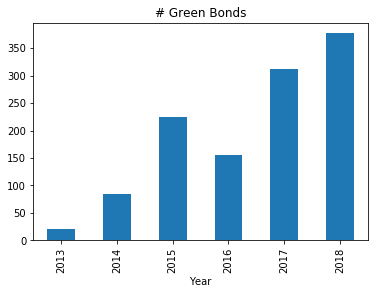

In [23]:
table1['# Bonds'].plot.bar(title='# Green Bonds')

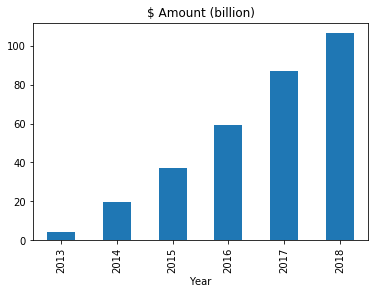

In [22]:
table1['$ Amount (billion)'].plot.bar(title='$ Amount (billion)')

# My Table 2. Corporate green bonds by industry

In [23]:
column = 'Sector'
table2 = pd.pivot_table(df,
                       index = [column],
                       values=['$ Amount (billion)'],
                       aggfunc={column: 'count', 
                                '$ Amount (billion)': np.sum})

In [24]:
table2.rename(columns={column: '# Bonds'}, inplace=True) # cannot sort if column.name == index.name
sorter = '# Bonds' #'Count'
table2 = table2[[sorter, '$ Amount (billion)']].sort_values(by=[sorter], ascending=False)

table2

,# Bonds,$ Amount (billion)
Sector,,
Utility - Other,315,35.635013
Banking,268,98.155956
Financial - Other,186,54.988683
Agency,149,80.100308
Home Builders,98,6.904014
Service - Other,33,7.240355
Gas Utility - Pipelines,17,0.053330
Real Estate Investment Trust,13,3.924677
Building Products,12,0.721665


# My Table 3. Corporate green bonds by country

In [25]:
pivot_column = 'Country of Incorporation' # Country of Issue uses 'Eurobond Mkt' for most EU

table3 = pd.pivot_table(df,
                       index = [pivot_column],
                       values=['$ Amount (billion)'],
                       aggfunc={pivot_column: 'count', 
                                '$ Amount (billion)': np.sum})

table3['# Bonds'] = table3[pivot_column]
table3 = table3[['# Bonds', '$ Amount (billion)']].sort_values('$ Amount (billion)', ascending=False)

table3

,# Bonds,$ Amount (billion)
Country of Incorporation,,
China,119,52.392145
Netherlands,50,36.857914
France,135,36.739956
Germany,50,31.223400
United States,198,29.145261
Sweden,156,16.096815
United Kingdom,25,11.078531
Spain,19,8.929351
Norway,28,7.953111


# My Table 4. Summary statistics at the green bond level 

In [26]:
public = df[df['Organization Is Public Flag'] == True]
private = df[df['Organization Is Public Flag'] == False]

public_table4 = dict()
private_table4 = dict()
all_firms_table4 = dict()

# combinations (dict, df, name: str)
df_to_info = ((all_firms_table4, df, 'All'), (private_table4, private, 'Private'),
              (public_table4, public, 'Public'))

table4_columns = list()  # list of dfs

# create a df (the column of the final df) for each combination
for dictionary, dataframe, col_name in df_to_info:
    dictionary['# Green bonds'] = len(dataframe.index)

    # number of unique days on which a given firm issues green bonds (summed across all firms)
    # group by Issuer, get Issue Date and len of np.array of unique values (.str. is required)
    dictionary['# Green bond issuer-days'] = dataframe.groupby('Issuer')['Issue Date'].unique(
    ).str.len().sum()

    dictionary['# Green bond issuer-years'] = dataframe.groupby('Issuer')['Year'].unique(
    ).str.len().sum()

    dictionary['# Green bond issuers'] = len(dataframe.Issuer.unique())
    dictionary['Amount (in $M)'] = round(dataframe['$ Amount (billion)'].mean(
    ) * 1000, 2)
    dictionary['Amount (in $M) Standard Deviation'] = round(
        dataframe['$ Amount (billion)'].std(), 2)
    dictionary['Certified (1/0)'] = np.NaN
    dictionary['Certified (1/0) Standard Deviation'] = np.NaN

    # get Maturity (years)
    dated = dataframe[['Issue Date', 'Maturity']].dropna()
    # cannot use vectorized subtraction due to date > 3000
    maturities_years = np.array(
        [(start - end.date()).days /
         365 for start, end in zip(
            dated.Maturity, dated['Issue Date'])
         ]
    )

    dictionary['Maturity (years)'] = round(np.mean(maturities_years), 2)
    dictionary['Maturity (years) Standard Deviation'] = round(
        np.std(maturities_years), 2)
    #

    # Coupon Class Description and Coupon Class differ 18 times. Former could be more correct, but contains 1 NaN.
    is_fixed = dataframe['Coupon Class Description'].fillna(
        dataframe['Current Coupon Class']).str.lower().str.contains('fixed')
    dictionary['Fixed-rate bond'] = round(
        sum(is_fixed) /
        len(dataframe.index), 2
    )
    dictionary['Fixed-rate bond Standard Deviation'] = round(dataframe[is_fixed].Coupon.astype(float).std(), 2)
    dictionary['Coupon (for fixed-rate bonds)'] = round(
        dataframe[is_fixed].Coupon.astype(float).mean(), 2)
    dictionary['Coupon (for fixed-rate bonds) Standard Deviation'] = round(
        dataframe[is_fixed].Coupon.astype(float).std(), 2)

    col = pd.DataFrame.from_dict(
        dictionary, orient='index', columns=[col_name])
    table4_columns.append(col)

# combine columns
table4 = pd.concat(table4_columns, axis=1)

# without at least 1 format(), formatting sucks
# table4.loc['Amount (in $M)'] = table4.loc['Amount (in $M)'].apply(
# '${0:,.2f}'.format)
# table4.loc['Amount (in $M) Standard Deviation'] = table4.loc['Amount (in $M) Standard Deviation'].apply(
#    '{0:,.2f}'.format)

table4

,All,Private,Public
# Green bonds,1175.00,923.00,251.00
# Green bond issuer-days,821.00,602.00,218.00
# Green bond issuer-years,578.00,394.00,184.00
# Green bond issuers,425.00,286.00,139.00
Amount (in $M),267.23,224.49,425.26
Amount (in $M) Standard Deviation,0.42,0.33,0.62
Certified (1/0),NaN,NaN,NaN
Certified (1/0) Standard Deviation,NaN,NaN,NaN
Maturity (years),7.75,7.21,9.74
Maturity (years) Standard Deviation,29.56,5.31,63.27


In [27]:
flammer_table4

,All,Private,Public
# Green bonds,1189,624,565
# Green bond issuer-days,775,391,384
# Green bond issuer-years,526,301,225
# Green bond issuers,400,231,169
Amount (in $M),253.4,245.5,262
Amount (in $M) Standard Deviation,421,329.5,503.3
Certified (1/0),0.656,0.684,0.625
Certified (1/0) Standard Deviation,0.475,0.465,0.485
Maturity (years),7.7,7.4,8.1
Maturity (years) Standard Deviation,29.5,5.5,42.3


# Compare Tables

In [ ]:
with pd.ExcelWriter('Table1.xlsx') as writer:
    table1.to_excel(writer, sheet_name='MyTable1')
    flammer_table1.to_excel(writer, sheet_name='FlammerTable1')
    (table1 - flammer_table1).to_excel(writer, sheet_name='Differences')

In [ ]:
table2.to_excel('Table2.xlsx')

In [ ]:
# get sum of rows not in flammer_table_3
others_bonds, others_amount = table3[~table3.index.isin(flammer_table3.index)].sum()

# table3 with same rows of flammer_table3
comparable_table3 = table3[table3.index.isin(flammer_table3.index)].append(pd.DataFrame({
    '# Bonds': others_bonds, '$ Amount (billion)': others_amount},
    index=['Others']))

with pd.ExcelWriter('Table3.xlsx') as writer:
    table3.to_excel(writer, sheet_name='MyTable3')
    comparable_table3.to_excel(writer, sheet_name='MyTable3SameIndex')
    flammer_table3.to_excel(writer, sheet_name='FlammerTable3')
    (comparable_table3 - flammer_table3).reindex(flammer_table3.index).to_excel(writer, sheet_name='Differences')

In [ ]:
with pd.ExcelWriter('Table4.xlsx') as writer:
    table4['Index'] = table4.index
    table4.to_excel(writer, sheet_name='MyTable4', index=False)
    worksheet = writer.sheets['MyTable4']  # pull worksheet object
    
    # format columns' width
    for idx, col in enumerate(table4):  # loop through all columns
        series = table4[col]
        max_len = max((
            series.astype(str).map(len).max(),  # len of largest item
            len(str(series.name))               # len of column name/header
            )) + 1  # adding a little extra space
        worksheet.set_column(idx, idx, max_len)  # set column width
    flammer_table4.to_excel(writer, sheet_name='FlammerTable4')
    (table4 - flammer_table4).loc[flammer_table4.index].to_excel(writer, sheet_name='Differences')

# Bloomberg

In [38]:
bloomberg = pd.read_csv('Bloomberg.csv', parse_dates=['Maturity', 'Issue Date', 'Announce Date'])
bloomberg = bloomberg[bloomberg['BICS Level 1'] != 'Government']
old_len = len(bloomberg.index)

bloomberg = bloomberg[bloomberg['Issue Date'].dt.year > 2012]
bloomberg = bloomberg[bloomberg['Issue Date'].dt.year < 2019]

bloomberg['$ Amount (billion)'] = bloomberg['Amt Out'].astype(float) / 1000000000
bloomberg['Year'] = bloomberg['Issue Date'].dt.year

print(f"Data shrunk from {old_len} to {len(bloomberg)} rows")

Data shrunk from 2682 to 1334 rows


In [ ]:
set(df.columns) & set(bloomberg.columns)

In [13]:
# merge Bloomberg and Refinitv
blref = df.merge(bloomberg, on='ISIN', how='outer')
print(f"Refinitiv had {len(df.index)} bonds, Bloomberg {len(bloomberg.index)}")
print(f"Added {len(blref.index)-len(df.index)} columns")

NameError: name 'df' is not defined

In [ ]:
blref.columns

In [ ]:
blref[blref['Maturity_x'] != blref['Maturity_y']][['Maturity_x', 'Maturity_y', 'Issuer', 'Issuer Name']]

In [ ]:
blref[blref['Issuer'] != blref['Issuer Name']][['Ticker_x', 'Ticker_y', 'Issuer', 'Issuer Name']]

In [ ]:
blref[blref['Cpn'] != blref['Coupon']][['Cpn', 'Coupon', 'Issuer', 'ISIN']]

In [ ]:
blref[blref['Coupon'] != blref['Cpn']][['Coupon', 'Cpn']]

# Rating

In [4]:
RATING_COLUMNS = ['DBRS Rating', 'Fitch Rating',
                  'Fitch Init Rtg', 'Moody Rtg', 'Mdy Init Rtg',
                  'S&P Rating', 'S&P Init Rtg', 'BBG Composite']

In [10]:
# DBRS Rating has too many NaNs
for column in RATING_COLUMNS:
    print(column, bloomberg[column].isna().sum())

DBRS Rating 2062
Fitch Rating 1685
Fitch Init Rtg 1685
Moody Rtg 1331
Mdy Init Rtg 1331
S&P Rating 1477
S&P Init Rtg 1477
BBG Composite 1191


In [18]:
# count values
for column in RATING_COLUMNS:
    print(column, bloomberg[column].value_counts(dropna=False))
    print('-' * 20)

DBRS Rating NaN     2062
AAAu      21
AAL        7
AA         4
AH         4
Au         3
AAA        2
AL         2
BBBH       2
BBB        2
AHu        2
A          2
AALu       1
AAHu       1
AAH        1
Name: DBRS Rating, dtype: int64
--------------------
Fitch Rating NaN        1685
NR           62
BBB          57
AAA          40
BBB+         32
A-           31
WD           30
A+           28
BBB-         27
A            22
AA-          20
AA           17
AAAu         16
BBB- *-       8
BB            8
BB+           7
D             6
BB-           6
B             3
AA- *-        2
BBBu          2
A-u           2
A *-          1
AAu           1
C             1
AA+           1
A+ *-         1
Name: Fitch Rating, dtype: int64
--------------------
Fitch Init Rtg NaN        1685
AAA          72
BBB          60
BBB+         56
A            45
AA-          30
AAAu         28
A+           26
BBB-         26
AA           16
A-           14
B            11
BB+          11
B+            9
BB

In [29]:
# they must be ordered to easily convert position (gotten by median) to rating
moodys_ratings = ['Aaa', 'Aa1', 'Aa2', 'Aa3', 'A1', 'A2', 'A3',
                  'Baa1', 'Baa2', 'Baa3', 'Ba1',
                  'Ba2', 'Ba3', 'B1', 'B2', 'B3', 'Caa1',
                  'Caa2', 'Caa3', 'Ca', 'C', 'D', 'WR', 'NR']
s_poors_ratings = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-',
                   'BB+', 'BB', 'BB-', 'BB-', 'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-', 'CC', 'C', 'D',
                   'WD', 'NR']

fitch_ratings = s_poors_ratings
bloomberg_ratings = s_poors_ratings
bbg_ratings = s_poors_ratings

In [30]:
col_to_rating_list = {
    'Moody Rtg': moodys_ratings,
    'S&P Rating': s_poors_ratings,
    'Fitch Rating': fitch_ratings
}

In [31]:
moodys_ratings_dict = {el: i for i, el in enumerate(moodys_ratings)}
s_poors_ratings_dict = {el: i for i, el in enumerate(s_poors_ratings)}
fitch_ratings_dict = s_poors_ratings_dict

In [33]:
# CHECK IF RATINGS ARE INCLUDED IN LIST
for rating_col, rating_list in col_to_rating_list.items():
    # pd.Series value[str]: count of occurrences[int]
    value_count = bloomberg[rating_col].value_counts(dropna=True) 
    errors = value_count[~value_count.index.isin(rating_list)]  # pd.Series of items not in ratings list
    errors_count = errors.sum()
    print(rating_col, errors_count)

Moody Rtg 8
S&P Rating 14
Fitch Rating 33


In [37]:
# CHECK IF RATINGS ARE INCLUDED IN LIST after REPLACING (' *-', 'u', 'p')
for rating_col, rating_list in col_to_rating_list.items():
    # pd.Series value[str]: count of occurrences[int]
    value_count = bloomberg[rating_col].str.replace(
        ' *-', '', regex=False).str.replace('u', '').str.replace('p', '').value_counts(dropna=True)
    # pd.Series of items not in ratings list
    errors = value_count[~value_count.index.isin(rating_list)]
    errors_count = errors.sum()
    print(rating_col, errors_count)

Moody Rtg 0
S&P Rating 0
Fitch Rating 0


In [9]:
bloomberg['BBG Composite'].unique()

array(['BBB', 'NR', 'A', 'A+', 'BBB+', 'A-', 'AA-', nan, 'AA', 'AA+',
       'AAA', 'D', 'B-', 'B', 'BB-', 'CCC-', 'DD+', 'BB', 'BB+', 'BBB-'],
      dtype=object)

In [16]:
moodys_ratings[
    int(
    bloomberg["Moody Rtg"].map(moodys_ratings_dict).dropna().median())
]

'Baa1'

In [17]:
moodys_ratings[int(bloomberg["Mdy Init Rtg"]. #str.replace('u', '').replace('Aa3 *-', 'Aa3').
                   map(moodys_ratings_dict).dropna().median())]

'A1'

In [338]:
original_table4

Index(['Asset Class_x', 'BICS Level 1', 'BICS Level 2', 'Market Cap', 'Cpn',
       'DBRS Rating', 'Announce Date', 'ESG Disclosure Score', 'Fitch Rating',
       'Fitch Init Rtg', 'Bloomberg ID', 'ISIN', 'Moody Rtg', 'Mdy Init Rtg',
       'Cntry of Incorp', 'S&P Rating', 'S&P Init Rtg', 'Issuer Name',
       'Issue Date', 'Final Maturity', 'Asset Class_y', 'Ticker', 'Maturity',
       'Curr', 'Amt Out', 'BBG Composite', 'Coupon Type'],
      dtype='object')

In [39]:
bloomberg_table1 = get_table1(bloomberg)

In [31]:
table1

,# Bonds,$ Amount (billion)
Year,,
2013,20,4.452512
2014,85,19.775665
2015,225,37.101881
2016,156,59.477087
2017,312,86.893720
2018,377,106.295753


In [40]:
bloomberg_table1

,# Bonds,$ Amount (billion)
Year,,
2013,17,3.687536
2014,82,7.482888
2015,269,14.603602
2016,182,46.415045
2017,351,74.622845
2018,433,94.092078


In [32]:
flammer_table1

,# Bonds,$ Amount (billion)
Year,,
2013,16,5.0
2014,76,15.4
2015,222,28.7
2016,156,68.7
2017,323,87.8
2018,396,95.7
